In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from keras.models import load_model
from time import time
from tensorflow.python.keras.callbacks import TensorBoard
from sklearn.metrics import roc_curve, auc
from keras.applications.nasnet import NASNetMobile
%matplotlib inline
print(tf.__version__)
print(keras.__version__)
print(np.__version__)

2.17.0
3.4.1
1.26.4


Image Preparation

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
train_path='/content/drive/MyDrive/Research/dataset/train/EnvironmentalFactors'
valid_path='/content/drive/MyDrive/Research/dataset/valid/Environmental Factors'
test_path='/content/drive/MyDrive/Research/dataset/test/Environmental Factors'

In [ ]:
from PIL import Image
img = Image.open('/content/drive/MyDrive/Research/dataset/train/EnvironmentalFactors/Dry/Dry_Abalone/AbDry (1).jpeg')
img = img.resize((128, 128))  # Resize image
img.save('resized_image.jpg')

In [ ]:
train_batches=ImageDataGenerator(preprocessing_function=keras.applications.nasnet.preprocess_input).flow_from_directory(train_path,target_size=(224,224),batch_size=10)
valid_batches=ImageDataGenerator(preprocessing_function=keras.applications.nasnet.preprocess_input).flow_from_directory(valid_path,target_size=(224,224),batch_size=10)
test_batches=ImageDataGenerator(preprocessing_function=keras.applications.nasnet.preprocess_input).flow_from_directory(test_path,target_size=(224,224),batch_size=10,shuffle=False)

Found 992 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


Modify Model

In [ ]:
model = NASNetMobile()

In [ ]:
model.summary()

Model: "nasnet_mobile"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv1 (Conv2D)       │ (None, 111, 111, 32)   │            864 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn1                  │ (None, 111, 111, 32)   │            128 │ stem_conv1[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2444           │ (None, 111, 111, 32)   │              0 │ stem_bn1[0][0]         │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reduction_conv_1_stem_1   │ (None, 111, 111, 11)   │            352 │ activation_2444[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reduction_bn_1_stem_1     │ (None, 111, 111, 11)   │             44 │ reduction_conv_1_stem… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2445           │ (None, 111, 111, 11)   │              0 │ reduction_bn_1_stem_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2447           │ (None, 111, 111, 32)   │              0 │ stem_bn1[0][0]         │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_pad_red… │ (None, 115, 115, 11)   │              0 │ activation_2445[0][0]  │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_pad_red… │ (None, 117, 117, 32)   │              0 │ activation_2447[0][0]  │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_reducti… │ (None, 56, 56, 11)     │            396 │ separable_conv_1_pad_… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_reducti… │ (None, 56, 56, 11)     │          1,920 │ separable_conv_1_pad_… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_bn_redu… │ (None, 56, 56, 11)     │             44 │ separable_conv_1_redu… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_bn_r

 Total params: 5,326,716 (20.32 MB)

 Trainable params: 5,289,978 (20.18 MB)

 Non-trainable params: 36,738 (143.51 KB)

In [ ]:
x=model.layers[-1].output
predictions=Dense(2,activation='softmax')(x)
model=Model(inputs=model.input,outputs=predictions)

In [ ]:
model.summary()

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv1 (Conv2D)       │ (None, 111, 111, 32)   │            864 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn1                  │ (None, 111, 111, 32)   │            128 │ stem_conv1[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2444           │ (None, 111, 111, 32)   │              0 │ stem_bn1[0][0]         │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reduction_conv_1_stem_1   │ (None, 111, 111, 11)   │            352 │ activation_2444[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reduction_bn_1_stem_1     │ (None, 111, 111, 11)   │             44 │ reduction_conv_1_stem… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2445           │ (None, 111, 111, 11)   │              0 │ reduction_bn_1_stem_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2447           │ (None, 111, 111, 32)   │              0 │ stem_bn1[0][0]         │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_pad_red… │ (None, 115, 115, 11)   │              0 │ activation_2445[0][0]  │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_pad_red… │ (None, 117, 117, 32)   │              0 │ activation_2447[0][0]  │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_reducti… │ (None, 56, 56, 11)     │            396 │ separable_conv_1_pad_… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_reducti… │ (None, 56, 56, 11)     │          1,920 │ separable_conv_1_pad_… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_bn_redu… │ (None, 56, 56, 11)     │             44 │ separable_conv_1_redu… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_bn_r

 Total params: 5,328,718 (20.33 MB)

 Trainable params: 5,291,980 (20.19 MB)

 Non-trainable params: 36,738 (143.51 KB)

In [ ]:
for layer in model.layers[:-5]:
    layer.trainable=False

Train the model

In [ ]:
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(train_batches,steps_per_epoch=90,validation_data=valid_batches,validation_steps=15,epochs=10,verbose=2)

Epoch 1/10
90/90 - 116s - 1s/step - accuracy: 0.8251 - loss: 0.6202 - val_accuracy: 0.3733 - val_loss: 0.7480
Epoch 2/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


90/90 - 20s - 227ms/step - accuracy: 0.9100 - loss: 0.5541 - val_accuracy: 0.3400 - val_loss: 0.7715
Epoch 3/10
90/90 - 83s - 923ms/step - accuracy: 0.9529 - loss: 0.4930 - val_accuracy: 0.3533 - val_loss: 0.8468
Epoch 4/10
90/90 - 22s - 243ms/step - accuracy: 0.9300 - loss: 0.4507 - val_accuracy: 0.3400 - val_loss: 0.8574
Epoch 5/10
90/90 - 84s - 935ms/step - accuracy: 0.9765 - loss: 0.4099 - val_accuracy: 0.2933 - val_loss: 0.9559
Epoch 6/10
90/90 - 18s - 203ms/step - accuracy: 0.9900 - loss: 0.3585 - val_accuracy: 0.3800 - val_loss: 0.8947
Epoch 7/10
90/90 - 79s - 882ms/step - accuracy: 0.9888 - loss: 0.3473 - val_accuracy: 0.3587 - val_loss: 0.9459
Epoch 8/10
90/90 - 19s - 215ms/step - accuracy: 0.9700 - loss: 0.3385 - val_accuracy: 0.4067 - val_loss: 0.9368
Epoch 9/10
90/90 - 126s - 1s/step - accuracy: 0.9922 - loss: 0.3006 - val_accuracy: 0.3600 - val_loss: 1.0346
Epoch 10/10
90/90 - 21s - 236ms/step - accuracy: 0.9800 - loss: 0.2872 - val_accuracy: 0.4467 - val_loss: 0.9377


In [ ]:
model.save(filepath="/content/drive/MyDrive/Research/save_model/saved-model.keras")

 Predict

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

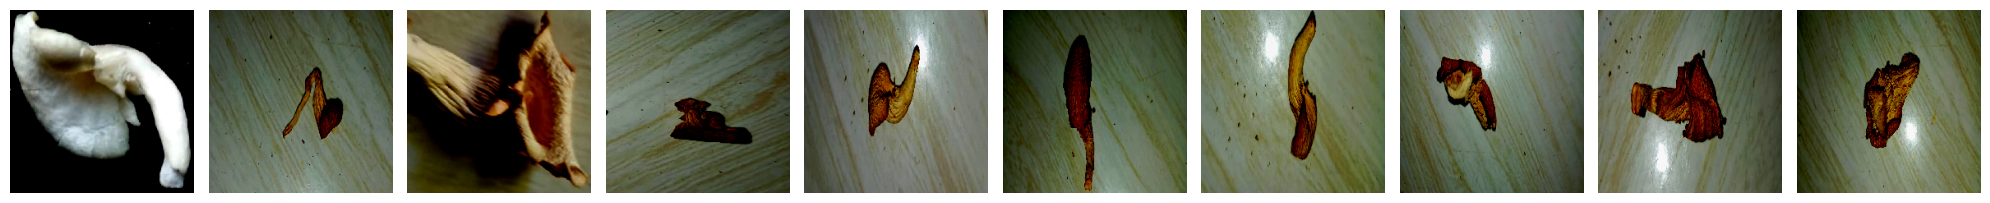

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [ ]:
test_imgs,test_labels=next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [ ]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
predictions=model.predict(x=test_batches,verbose=0)

In [ ]:
np.round(predictions)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
cm=confusion_matrix(y_true=test_batches.classes,y_pred=np.argmax(predictions,axis=-1))

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
test_batches.class_indices

{'Abalone': 0, 'American Oyester': 1}

Confusion matrix, without normalization
[[241 232]
 [391 128]]


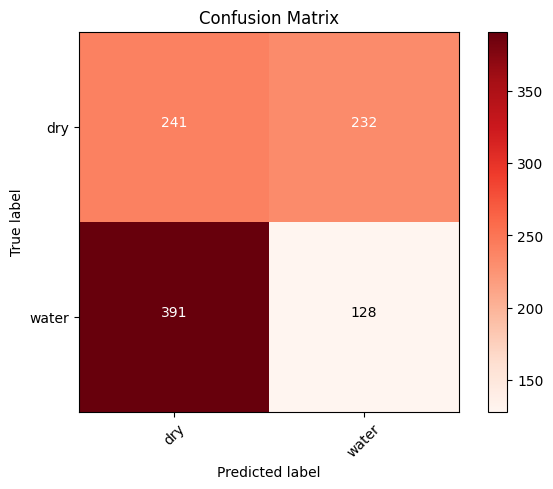

In [ ]:
cm_plot_labels=['dry','water']
plt.figure()
plot_confusion_matrix(cm,cm_plot_labels,title='Confusion Matrix')

# Evaluation

In [ ]:
yTrue = test_batches.classes
yPred = np.argmax(predictions,axis=-1)

sum(yPred == yTrue)
len(yPred)

CalculatedAccuracy = sum(yPred == yTrue)/len(yPred)
print("Calculated Accuracy : ")
print(CalculatedAccuracy*100)

Calculated Accuracy : 
37.19758064516129


# Save trained keras model

In [ ]:
model.save('environmentalfactor.h5')

# Do predictions from saved model

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import datetime
import time
model=load_model('environmentalfactor.h5')

# Prediction

In [ ]:
import os
from keras.preprocessing import image
from keras.applications.nasnet import preprocess_input

path  = ('/content/drive/MyDrive/Research/dataset/test/')
filenames = os.listdir(path)
for file in filenames:
    print(file)
    img_path='/content/drive/MyDrive/Research/dataset/test/Environmental Factors/Abalone/Abalone - Dry Effects/AbDry (1).jpeg'
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    result1=model.predict(x)
    list1 = result1.tolist()
    finalresult=list1[0]
    max_value = max(finalresult)
    max_index = finalresult.index(max_value)


    print(max_value)
    if max_index==0:
        print("Abalone")
    elif max_index==1:
        print("American Oyester")

Environmental Factors
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
0.7985864877700806
Abalone


# Demo

In [ ]:
mushroom_data = {
    "dry": {
        "Edible": "Non-Edible",
        "Eate": "Not Suitable",
        "Nutrition": {
            "Calories": 28,
            "Fat": 0.3,
            "Carbohydrates": 5.2,
            "Fiber": 2,
            "Sugar": 0.95,
            "Protein": 2.9
        }
    },
    "water": {
        "Edible": "Non-Edible",
        "Eate": "Not Suitable",
        "Nutrition": {
            "Calories": 15,
            "Fat": 0.24,
            "Carbohydrates": 2.3,
            "Fiber": 0.7,
            "Sugar": 1.4,
            "Protein": 2.2
        }
    }
}

In [ ]:
def display_mushroom_data(mushroom_type):
    if mushroom_type in mushroom_data:
        mushroom = mushroom_data[mushroom_type]
        print(f"--- {mushroom_type} ---")
        print(f"Edible: {mushroom['Edible']}")
        print(f"Eate: {mushroom['Eate']}")

        print("\nNutrition details per 100g:")
        for nutrient, value in mushroom['Nutrition'].items():
            print(f"{nutrient}: {value} {'%' if '%' in str(value) else 'g'}")

        print("\n--- End of Data ---")
    else:
        print(f"Error: Mushroom type '{mushroom_type}' not found.")